In [105]:
import gymnasium as gym
import numpy as np
import d3rlpy
import pickle

import matplotlib.pyplot as plt
from env.atari.represented_atari_game import GymCompatWrapper2
from online_main import OneHotWrapper
from pretrain_from_llm import get_llm_data_paths

hyperparams = {
        "env": "MountainCar-v0", #CartPole-v0, Pendulum-v1, MountainCar-v0, FrozenLake-v1, CliffWalking-v0, RepresentedPong-v0
        "seed": 42069,
        "n_episodes": 300,
        "max_episode_len": 200, # Around 10h per 100k steps in Leviathan server
        "eps": 0.1,  # epsilon for exploration
        "n_exp": 5,
        "n_pretrain_eps": 30,
        "n_online_eps": 270, #10-5990 for mountainCar, 30-120 for CartPole
        "gpu": True, # True if use GPU to train with d3rlpy
        "buffer_size": 100000, #Test with 100k, 200k, 500k. 1M might be too much
        "data_path": None,#'data/CartPole_Qwen2.5-7B-Instruct_Neps_10_20250406040150.pkl',
        "model_path": None,#'d3rlpy_loss/DoubleDQN_online_20250331153346/model_600000.d3',
        "batch_size":256, #Test smaller batch size: 32, 64. May be noisier
        "learning_rate":5e-5,
        "gamma":0.99,
        "target_update_interval":1000, #Test with 1k, 2k, 5k
        "smooth": 10# For plotting, smooth the curve with this window size
    }

assert hyperparams["n_episodes"]==hyperparams["n_pretrain_eps"]+hyperparams["n_online_eps"], "Check n_episodes=n_pretrain_eps+n_online_eps"

if "Represented" in hyperparams["env"]:
    env = GymCompatWrapper2(gym.make(hyperparams["env"]))
    eval_env = GymCompatWrapper2(gym.make(hyperparams["env"]))
elif isinstance(gym.make(hyperparams["env"]).observation_space, gym.spaces.Discrete):
    env = OneHotWrapper(gym.make(hyperparams["env"]))
    eval_env = OneHotWrapper(gym.make(hyperparams["env"]))
else:
    env = gym.make(hyperparams["env"])
    eval_env = gym.make(hyperparams["env"])

# fix seed
d3rlpy.seed(hyperparams["seed"])
d3rlpy.envs.seed_env(env, hyperparams["seed"])
d3rlpy.envs.seed_env(eval_env, hyperparams["seed"])

### Static/pretrain data

In [106]:
path_7b, path_32b = get_llm_data_paths(hyperparams["env"])

with open(path_7b, 'rb') as file:
    Qwen_7B_dataset = pickle.load(file)
with open(path_32b, 'rb') as file:
    Qwen_32B_dataset = pickle.load(file)

Qwen_32B_rewards = []
for i in range(hyperparams["n_pretrain_eps"]):
    Qwen_32B_rewards.append(Qwen_32B_dataset.episodes[i].compute_return())
Qwen_7B_rewards = []
for i in range(hyperparams["n_pretrain_eps"]):
    Qwen_7B_rewards.append(Qwen_7B_dataset.episodes[i].compute_return())

Qwen_7B = hyperparams["n_episodes"] * [np.mean(Qwen_7B_rewards)]
Qwen_32B = hyperparams["n_episodes"] * [np.mean(Qwen_32B_rewards)]
# Qwen_7B = Qwen_7B_rewards + hyperparams["n_online_eps"] * [np.mean(Qwen_7B_rewards)]
# Qwen_32B = Qwen_32B_rewards + hyperparams["n_online_eps"] * [np.mean(Qwen_32B_rewards)]

print("Qwen_32B: ", np.mean(Qwen_7B_rewards))
print("Qwen_7B: ", np.mean(Qwen_32B_rewards))

Qwen_32B:  -200.0
Qwen_7B:  -100.0


In [107]:
try:
    env_name = hyperparams['env'].split("-")[0]
    if env_name == "Pendulum":
        path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250422210707SFT.pkl"
    elif env_name == "CliffWalking":
        path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250505135458SFT.pkl"
        # path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250421175530SFT.pkl" #CliffWalking typo
    elif env_name == "FrozenLake":
        path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250501013018SFT.pkl"
        # path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250421120400SFT.pkl" #FrozenLake typo

    with open(path_SFT, 'rb') as file:
        Qwen_7B_SFT_dataset = pickle.load(file)

    Qwen_7B_SFT_rewards = []
    for i in range(hyperparams["n_pretrain_eps"]):
        Qwen_7B_SFT_rewards.append(Qwen_7B_SFT_dataset.episodes[i].compute_return())
    Qwen_7B_SFT = Qwen_7B_SFT_rewards + hyperparams["n_online_eps"] * [np.mean(Qwen_7B_SFT_rewards)]
    print("Qwen_7B_SFT: ", np.mean(Qwen_7B_SFT_rewards))
except:
    Qwen_7B_SFT = None
try:
    path_DS_7B = f"data/{hyperparams['env'].split('-')[0]}_DeepSeek-R1-Distill-Qwen-7B_Neps_{hyperparams['n_pretrain_eps']}_20250502071148.pkl" #FrozenLake
    path_DS_14B = f"data/{hyperparams['env'].split('-')[0]}_DeepSeek-R1-Distill-Qwen-14B_Neps_{hyperparams['n_pretrain_eps']}_20250502084016.pkl" #FrozenLake
    # path_DS_7B = f"data/{hyperparams['env'].split('-')[0]}_DeepSeek-R1-Distill-Qwen-7B_Neps_{hyperparams['n_pretrain_eps']}_20250419172821.pkl" #FrozenLake typo
    # path_DS_14B = f"data/{hyperparams['env'].split('-')[0]}_DeepSeek-R1-Distill-Qwen-14B_Neps_{hyperparams['n_pretrain_eps']}_20250422000525.pkl" #FrozenLake typo
    with open(path_DS_7B, 'rb') as file:
        DS_7B_dataset = pickle.load(file)
    with open(path_DS_14B, 'rb') as file:
        DS_14B_dataset = pickle.load(file)
    DS_7B_rewards = []
    for i in range(hyperparams["n_pretrain_eps"]):
        DS_7B_rewards.append(DS_7B_dataset.episodes[i].compute_return())
    DS_14B_rewards = []
    for i in range(hyperparams["n_pretrain_eps"]):
        DS_14B_rewards.append(DS_14B_dataset.episodes[i].compute_return())

    # DS_7B = hyperparams["n_episodes"] * [np.mean(DS_7B_rewards)]
    # DS_14B = hyperparams["n_episodes"] * [np.mean(DS_14B_rewards)]
    DS_7B = DS_7B_rewards + hyperparams["n_online_eps"] * [np.mean(DS_7B_rewards)]
    DS_14B = DS_14B_rewards + hyperparams["n_online_eps"] * [np.mean(DS_14B_rewards)]

    print("DS_7B: ", np.mean(DS_7B_rewards))
    print("DS_14B: ", np.mean(DS_14B_rewards))
except:
    DS_7B = None
    DS_14B = None

Qwen_7B_SFT:  0.0


### Generate and evaluate random baseline

In [108]:
# Evaluate the random policy manually
random_rewards = []
for _ in range(hyperparams["n_pretrain_eps"]):
	obs, _ = env.reset()
	done = False
	total_reward = 0
	count = 0
	while not done:
		action = env.action_space.sample()
		obs, reward, done, _, _ = env.step(action)
		total_reward += reward
		count += 1
		if count >= hyperparams["max_episode_len"]:
			break
	random_rewards.append(total_reward)

mean_random = np.ones(hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]) * np.mean(random_rewards)
# Print the average reward of the random policy
print(f"Average reward for random policy: {mean_random[0]}")

Average reward for random policy: -200.0


# Plot

In [109]:
def extract_data(hyperparams, Qwen_7B, Qwen_32B, DS_7B, DS_14B, Qwen_7B_SFT):
    # suffix = "_typo" # For debugging
    suffix = ""
    with open(f"data/cache_{hyperparams['env'].split('-')[0]}_Neps_10{suffix}.pkl", 'rb') as file:
        cache10 = pickle.load(file)
    with open(f"data/cache_{hyperparams['env'].split('-')[0]}_Neps_20{suffix}.pkl", 'rb') as file:
        cache20 = pickle.load(file)
    with open(f"data/cache_{hyperparams['env'].split('-')[0]}_Neps_30{suffix}.pkl", 'rb') as file:
        cache30 = pickle.load(file)
    with open(f'data/cache_{hyperparams["env"].split("-")[0]}_on_policy_pretrain_exp.pkl', 'rb') as file:
        on_policy_pretrain_cache = pickle.load(file)
    with open(f'data/cache_{hyperparams["env"].split("-")[0]}_on_policy_pretrain_exp_rand.pkl', 'rb') as file:
        rand_pretrain_cache = pickle.load(file)
    try:
        with open(f"data/cache_{hyperparams['env'].split('-')[0]}_Neps_10SFT{suffix}.pkl", 'rb') as file:
            cache10SFT = pickle.load(file)
        with open(f"data/cache_{hyperparams['env'].split('-')[0]}_Neps_20SFT{suffix}.pkl", 'rb') as file:
            cache20SFT = pickle.load(file)
        with open(f"data/cache_{hyperparams['env'].split('-')[0]}_Neps_30SFT{suffix}.pkl", 'rb') as file:
            cache30SFT = pickle.load(file)
        pretrain_7b_1000_pre_10SFT_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        pretrain_7b_3000_pre_10SFT_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        pretrain_7b_1000_pre_20SFT_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        pretrain_7b_3000_pre_20SFT_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        pretrain_7b_1000_pre_30SFT_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        pretrain_7b_3000_pre_30SFT_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))

        for i in range(hyperparams["n_exp"]):
            for j in range(hyperparams["n_episodes"]-10):
                pretrain_7b_1000_pre_10SFT_returns[i][10+j] = cache10SFT[f"pretrain_7b_1000_{i}"][j]
                pretrain_7b_3000_pre_10SFT_returns[i][10+j] = cache10SFT[f"pretrain_7b_3000_{i}"][j]

            for j in range(hyperparams["n_episodes"]-20):
                pretrain_7b_1000_pre_20SFT_returns[i][20+j] = cache20SFT[f"pretrain_7b_1000_{i}"][j]
                pretrain_7b_3000_pre_20SFT_returns[i][20+j] = cache20SFT[f"pretrain_7b_3000_{i}"][j]

            for j in range(hyperparams["n_episodes"]-30):
                pretrain_7b_1000_pre_30SFT_returns[i][30+j] = cache30SFT[f"pretrain_7b_1000_{i}"][j]
                pretrain_7b_3000_pre_30SFT_returns[i][30+j] = cache30SFT[f"pretrain_7b_3000_{i}"][j]
        mean_pretrain_7b_1000_pre_10SFT = np.mean(pretrain_7b_1000_pre_10SFT_returns, axis = 0)
        std_pretrain_7b_1000_pre_10SFT = np.std(pretrain_7b_1000_pre_10SFT_returns, axis = 0)
        mean_pretrain_7b_3000_pre_10SFT = np.mean(pretrain_7b_3000_pre_10SFT_returns, axis = 0)
        std_pretrain_7b_3000_pre_10SFT = np.std(pretrain_7b_3000_pre_10SFT_returns, axis = 0)
        mean_pretrain_7b_1000_pre_10SFT[:10] = Qwen_7B_SFT[:10]
        mean_pretrain_7b_3000_pre_10SFT[:10] = Qwen_7B_SFT[:10]

        mean_pretrain_7b_1000_pre_20SFT = np.mean(pretrain_7b_1000_pre_20SFT_returns, axis = 0)
        std_pretrain_7b_1000_pre_20SFT = np.std(pretrain_7b_1000_pre_20SFT_returns, axis = 0)
        mean_pretrain_7b_3000_pre_20SFT = np.mean(pretrain_7b_3000_pre_20SFT_returns, axis = 0)
        std_pretrain_7b_3000_pre_20SFT = np.std(pretrain_7b_3000_pre_20SFT_returns, axis = 0)
        mean_pretrain_7b_1000_pre_20SFT[:20] = Qwen_7B_SFT[:20]
        mean_pretrain_7b_3000_pre_20SFT[:20] = Qwen_7B_SFT[:20]

        mean_pretrain_7b_1000_pre_30SFT = np.mean(pretrain_7b_1000_pre_30SFT_returns, axis = 0)
        std_pretrain_7b_1000_pre_30SFT = np.std(pretrain_7b_1000_pre_30SFT_returns, axis = 0)
        mean_pretrain_7b_3000_pre_30SFT = np.mean(pretrain_7b_3000_pre_30SFT_returns, axis = 0)
        std_pretrain_7b_3000_pre_30SFT = np.std(pretrain_7b_3000_pre_30SFT_returns, axis = 0)
        mean_pretrain_7b_1000_pre_30SFT[:30] = Qwen_7B_SFT[:30]
        mean_pretrain_7b_3000_pre_30SFT[:30] = Qwen_7B_SFT[:30]
        out_dict_SFT = {
            "mean_pretrain_7b_1000_pre_10SFT": mean_pretrain_7b_1000_pre_10SFT,
            "std_pretrain_7b_1000_pre_10SFT": std_pretrain_7b_1000_pre_10SFT,
            "mean_pretrain_7b_3000_pre_10SFT": mean_pretrain_7b_3000_pre_10SFT,
            "std_pretrain_7b_3000_pre_10SFT": std_pretrain_7b_3000_pre_10SFT,
            "mean_pretrain_7b_1000_pre_20SFT": mean_pretrain_7b_1000_pre_20SFT,
            "std_pretrain_7b_1000_pre_20SFT": std_pretrain_7b_1000_pre_20SFT,
            "mean_pretrain_7b_3000_pre_20SFT": mean_pretrain_7b_3000_pre_20SFT,
            "std_pretrain_7b_3000_pre_20SFT": std_pretrain_7b_3000_pre_20SFT,
            "mean_pretrain_7b_1000_pre_30SFT": mean_pretrain_7b_1000_pre_30SFT,
            "std_pretrain_7b_1000_pre_30SFT": std_pretrain_7b_1000_pre_30SFT,
            "mean_pretrain_7b_3000_pre_30SFT": mean_pretrain_7b_3000_pre_30SFT,
            "std_pretrain_7b_3000_pre_30SFT": std_pretrain_7b_3000_pre_30SFT
        }
    except:
        pass
    try:
        with open(f"data/cache_{hyperparams['env'].split('-')[0]}_Neps_10DS{suffix}.pkl", 'rb') as file:
            cache10DS = pickle.load(file)
        with open(f"data/cache_{hyperparams['env'].split('-')[0]}_Neps_20DS{suffix}.pkl", 'rb') as file:
            cache20DS = pickle.load(file)
        with open(f"data/cache_{hyperparams['env'].split('-')[0]}_Neps_30DS{suffix}.pkl", 'rb') as file:
            cache30DS = pickle.load(file)
        pretrain_7b_1000_pre_10DS_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        pretrain_7b_3000_pre_10DS_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        pretrain_14b_1000_pre_10DS_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        pretrain_14b_3000_pre_10DS_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        pretrain_7b_1000_pre_20DS_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        pretrain_7b_3000_pre_20DS_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        pretrain_14b_1000_pre_20DS_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        pretrain_14b_3000_pre_20DS_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        pretrain_7b_1000_pre_30DS_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        pretrain_7b_3000_pre_30DS_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        pretrain_14b_1000_pre_30DS_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        pretrain_14b_3000_pre_30DS_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
        for i in range(hyperparams["n_exp"]):
            for j in range(hyperparams["n_episodes"]-10):
                pretrain_7b_1000_pre_10DS_returns[i][10+j] = cache10DS[f"pretrain_7b_1000_{i}"][j]
                pretrain_14b_1000_pre_10DS_returns[i][10+j] = cache10DS[f"pretrain_32b_1000_{i}"][j]
                pretrain_7b_3000_pre_10DS_returns[i][10+j] = cache10DS[f"pretrain_7b_3000_{i}"][j]
                pretrain_14b_3000_pre_10DS_returns[i][10+j] = cache10DS[f"pretrain_32b_3000_{i}"][j]

            for j in range(hyperparams["n_episodes"]-20):
                pretrain_7b_1000_pre_20DS_returns[i][20+j] = cache20DS[f"pretrain_7b_1000_{i}"][j]
                pretrain_14b_1000_pre_20DS_returns[i][20+j] = cache20DS[f"pretrain_32b_1000_{i}"][j]
                pretrain_7b_3000_pre_20DS_returns[i][20+j] = cache20DS[f"pretrain_7b_3000_{i}"][j]
                pretrain_14b_3000_pre_20DS_returns[i][20+j] = cache20DS[f"pretrain_32b_3000_{i}"][j]

            for j in range(hyperparams["n_episodes"]-30):
                pretrain_7b_1000_pre_30DS_returns[i][30+j] = cache30DS[f"pretrain_7b_1000_{i}"][j]
                pretrain_14b_1000_pre_30DS_returns[i][30+j] = cache30DS[f"pretrain_32b_1000_{i}"][j]
                pretrain_7b_3000_pre_30DS_returns[i][30+j] = cache30DS[f"pretrain_7b_3000_{i}"][j]
                pretrain_14b_3000_pre_30DS_returns[i][30+j] = cache30DS[f"pretrain_32b_3000_{i}"][j]
        mean_pretrain_7b_1000_pre_10DS = np.mean(pretrain_7b_1000_pre_10DS_returns, axis = 0)
        std_pretrain_7b_1000_pre_10DS = np.std(pretrain_7b_1000_pre_10DS_returns, axis = 0)
        mean_pretrain_7b_3000_pre_10DS = np.mean(pretrain_7b_3000_pre_10DS_returns, axis = 0)
        std_pretrain_7b_3000_pre_10DS = np.std(pretrain_7b_3000_pre_10DS_returns, axis = 0)
        mean_pretrain_14b_1000_pre_10DS = np.mean(pretrain_14b_1000_pre_10DS_returns, axis = 0)
        std_pretrain_14b_1000_pre_10DS = np.std(pretrain_14b_1000_pre_10DS_returns, axis = 0)
        mean_pretrain_14b_3000_pre_10DS = np.mean(pretrain_14b_3000_pre_10DS_returns, axis = 0)
        std_pretrain_14b_3000_pre_10DS = np.std(pretrain_14b_3000_pre_10DS_returns, axis = 0)
        mean_pretrain_14b_1000_pre_10DS[:10] = DS_14B[:10]
        mean_pretrain_7b_1000_pre_10DS[:10] = DS_7B[:10]
        mean_pretrain_14b_3000_pre_10DS[:10] = DS_14B[:10]
        mean_pretrain_7b_3000_pre_10DS[:10] = DS_7B[:10]

        mean_pretrain_7b_1000_pre_20DS = np.mean(pretrain_7b_1000_pre_20DS_returns, axis = 0)
        std_pretrain_7b_1000_pre_20DS = np.std(pretrain_7b_1000_pre_20DS_returns, axis = 0)
        mean_pretrain_7b_3000_pre_20DS = np.mean(pretrain_7b_3000_pre_20DS_returns, axis = 0)
        std_pretrain_7b_3000_pre_20DS = np.std(pretrain_7b_3000_pre_20DS_returns, axis = 0)
        mean_pretrain_14b_1000_pre_20DS = np.mean(pretrain_14b_1000_pre_20DS_returns, axis = 0)
        std_pretrain_14b_1000_pre_20DS = np.std(pretrain_14b_1000_pre_20DS_returns, axis = 0)
        mean_pretrain_14b_3000_pre_20DS = np.mean(pretrain_14b_3000_pre_20DS_returns, axis = 0)
        std_pretrain_14b_3000_pre_20DS = np.std(pretrain_14b_3000_pre_20DS_returns, axis = 0)
        mean_pretrain_14b_1000_pre_20DS[:20] = DS_14B[:20]
        mean_pretrain_7b_1000_pre_20DS[:20] = DS_7B[:20]
        mean_pretrain_14b_3000_pre_20DS[:20] = DS_14B[:20]
        mean_pretrain_7b_3000_pre_20DS[:20] = DS_7B[:20]

        mean_pretrain_7b_1000_pre_30DS = np.mean(pretrain_7b_1000_pre_30DS_returns, axis = 0)
        std_pretrain_7b_1000_pre_30DS = np.std(pretrain_7b_1000_pre_30DS_returns, axis = 0)
        mean_pretrain_7b_3000_pre_30DS = np.mean(pretrain_7b_3000_pre_30DS_returns, axis = 0)
        std_pretrain_7b_3000_pre_30DS = np.std(pretrain_7b_3000_pre_30DS_returns, axis = 0)
        mean_pretrain_14b_1000_pre_30DS = np.mean(pretrain_14b_1000_pre_30DS_returns, axis = 0)
        std_pretrain_14b_1000_pre_30DS = np.std(pretrain_14b_1000_pre_30DS_returns, axis = 0)
        mean_pretrain_14b_3000_pre_30DS = np.mean(pretrain_14b_3000_pre_30DS_returns, axis = 0)
        std_pretrain_14b_3000_pre_30DS = np.std(pretrain_14b_3000_pre_30DS_returns, axis = 0)
        mean_pretrain_14b_1000_pre_30DS[:30] = DS_14B[:30]
        mean_pretrain_7b_1000_pre_30DS[:30] = DS_7B[:30]
        mean_pretrain_14b_3000_pre_30DS[:30] = DS_14B[:30]
        mean_pretrain_7b_3000_pre_30DS[:30] = DS_7B[:30]
        out_dict_DS = {
            "mean_pretrain_7b_1000_pre_10DS": mean_pretrain_7b_1000_pre_10DS,
            "std_pretrain_7b_1000_pre_10DS": std_pretrain_7b_1000_pre_10DS,
            "mean_pretrain_7b_3000_pre_10DS": mean_pretrain_7b_3000_pre_10DS,
            "std_pretrain_7b_3000_pre_10DS": std_pretrain_7b_3000_pre_10DS,
            "mean_pretrain_14b_1000_pre_10DS": mean_pretrain_14b_1000_pre_10DS,
            "std_pretrain_14b_1000_pre_10DS": std_pretrain_14b_1000_pre_10DS,
            "mean_pretrain_14b_3000_pre_10DS": mean_pretrain_14b_3000_pre_10DS,
            "std_pretrain_14b_3000_pre_10DS": std_pretrain_14b_3000_pre_10DS,
            "mean_pretrain_7b_1000_pre_20DS": mean_pretrain_7b_1000_pre_20DS,
            "std_pretrain_7b_1000_pre_20DS": std_pretrain_7b_1000_pre_20DS,
            "mean_pretrain_7b_3000_pre_20DS": mean_pretrain_7b_3000_pre_20DS,
            "std_pretrain_7b_3000_pre_20DS": std_pretrain_7b_3000_pre_20DS,
            "mean_pretrain_14b_1000_pre_20DS": mean_pretrain_14b_1000_pre_20DS,
            "std_pretrain_14b_1000_pre_20DS": std_pretrain_14b_1000_pre_20DS,
            "mean_pretrain_14b_3000_pre_20DS": mean_pretrain_14b_3000_pre_20DS,
            "std_pretrain_14b_3000_pre_20DS": std_pretrain_14b_3000_pre_20DS,
            "mean_pretrain_7b_1000_pre_30DS": mean_pretrain_7b_1000_pre_30DS,
            "std_pretrain_7b_1000_pre_30DS": std_pretrain_7b_1000_pre_30DS,
            "mean_pretrain_7b_3000_pre_30DS": mean_pretrain_7b_3000_pre_30DS,
            "std_pretrain_7b_3000_pre_30DS": std_pretrain_7b_3000_pre_30DS,
            "mean_pretrain_14b_1000_pre_30DS": mean_pretrain_14b_1000_pre_30DS,
            "std_pretrain_14b_1000_pre_30DS": std_pretrain_14b_1000_pre_30DS,
            "mean_pretrain_14b_3000_pre_30DS": mean_pretrain_14b_3000_pre_30DS,
            "std_pretrain_14b_3000_pre_30DS": std_pretrain_14b_3000_pre_30DS
        }
    except:
        pass
    online_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    mix_7b_pre_10_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    mix_32b_pre_10_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    pretrain_7b_1000_pre_10_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    pretrain_32b_1000_pre_10_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    pretrain_7b_3000_pre_10_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    pretrain_32b_3000_pre_10_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    on_pol_pretrain_1000_pre_10_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    on_pol_pretrain_3000_pre_10_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    rand_pretrain_1000_pre_10_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    rand_pretrain_3000_pre_10_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))

    mix_7b_pre_20_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    mix_32b_pre_20_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    pretrain_7b_1000_pre_20_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    pretrain_32b_1000_pre_20_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    pretrain_7b_3000_pre_20_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    pretrain_32b_3000_pre_20_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    on_pol_pretrain_1000_pre_20_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    on_pol_pretrain_3000_pre_20_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    rand_pretrain_1000_pre_20_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    rand_pretrain_3000_pre_20_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))

    mix_7b_pre_30_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    mix_32b_pre_30_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    pretrain_7b_1000_pre_30_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    pretrain_32b_1000_pre_30_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    pretrain_7b_3000_pre_30_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    pretrain_32b_3000_pre_30_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    on_pol_pretrain_1000_pre_30_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    on_pol_pretrain_3000_pre_30_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    rand_pretrain_1000_pre_30_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))
    rand_pretrain_3000_pre_30_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_episodes"]))

    for i in range(hyperparams["n_exp"]):
        # online_returns[i] = cache10[f"online_{i}"]
        online_returns[i] = cache10[f"online_{i}"][:hyperparams["n_episodes"]] #Quick-fix for MountainCar
        on_pol_pretrain_1000_pre_10_returns[i] = on_policy_pretrain_cache[f'pretrain_10_eps_1000_steps_{i}'][:hyperparams["n_episodes"]]
        on_pol_pretrain_3000_pre_10_returns[i] = on_policy_pretrain_cache[f'pretrain_10_eps_3000_steps_{i}'][:hyperparams["n_episodes"]]
        on_pol_pretrain_1000_pre_20_returns[i] = on_policy_pretrain_cache[f'pretrain_20_eps_1000_steps_{i}'][:hyperparams["n_episodes"]]
        on_pol_pretrain_3000_pre_20_returns[i] = on_policy_pretrain_cache[f'pretrain_20_eps_3000_steps_{i}'][:hyperparams["n_episodes"]]
        on_pol_pretrain_1000_pre_30_returns[i] = on_policy_pretrain_cache[f'pretrain_30_eps_1000_steps_{i}'][:hyperparams["n_episodes"]]
        on_pol_pretrain_3000_pre_30_returns[i] = on_policy_pretrain_cache[f'pretrain_30_eps_3000_steps_{i}'][:hyperparams["n_episodes"]]

        rand_pretrain_1000_pre_10_returns[i] = rand_pretrain_cache[f'pretrain_10_eps_1000_steps_{i}_rand'][:hyperparams["n_episodes"]]
        rand_pretrain_3000_pre_10_returns[i] = rand_pretrain_cache[f'pretrain_10_eps_3000_steps_{i}_rand'][:hyperparams["n_episodes"]]
        rand_pretrain_1000_pre_20_returns[i] = rand_pretrain_cache[f'pretrain_20_eps_1000_steps_{i}_rand'][:hyperparams["n_episodes"]]
        rand_pretrain_3000_pre_20_returns[i] = rand_pretrain_cache[f'pretrain_20_eps_3000_steps_{i}_rand'][:hyperparams["n_episodes"]]
        rand_pretrain_1000_pre_30_returns[i] = rand_pretrain_cache[f'pretrain_30_eps_1000_steps_{i}_rand'][:hyperparams["n_episodes"]]
        rand_pretrain_3000_pre_30_returns[i] = rand_pretrain_cache[f'pretrain_30_eps_3000_steps_{i}_rand'][:hyperparams["n_episodes"]]
        for j in range(hyperparams["n_episodes"]-10):
            mix_7b_pre_10_returns[i][10+j] = cache10[f"finetune_7b_{i}"][j]
            mix_32b_pre_10_returns[i][10+j] = cache10[f"finetune_32b_{i}"][j]
            pretrain_7b_1000_pre_10_returns[i][10+j] = cache10[f"pretrain_7b_1000_{i}"][j]
            pretrain_32b_1000_pre_10_returns[i][10+j] = cache10[f"pretrain_32b_1000_{i}"][j]
            pretrain_7b_3000_pre_10_returns[i][10+j] = cache10[f"pretrain_7b_3000_{i}"][j]
            pretrain_32b_3000_pre_10_returns[i][10+j] = cache10[f"pretrain_32b_3000_{i}"][j]

        for j in range(hyperparams["n_episodes"]-20):
            mix_7b_pre_20_returns[i][20+j] = cache20[f"finetune_7b_{i}"][j]
            mix_32b_pre_20_returns[i][20+j] = cache20[f"finetune_32b_{i}"][j]
            pretrain_7b_1000_pre_20_returns[i][20+j] = cache20[f"pretrain_7b_1000_{i}"][j]
            pretrain_32b_1000_pre_20_returns[i][20+j] = cache20[f"pretrain_32b_1000_{i}"][j]
            pretrain_7b_3000_pre_20_returns[i][20+j] = cache20[f"pretrain_7b_3000_{i}"][j]
            pretrain_32b_3000_pre_20_returns[i][20+j] = cache20[f"pretrain_32b_3000_{i}"][j]

        for j in range(hyperparams["n_episodes"]-30):
            mix_7b_pre_30_returns[i][30+j] = cache30[f"finetune_7b_{i}"][j]
            mix_32b_pre_30_returns[i][30+j] = cache30[f"finetune_32b_{i}"][j]
            pretrain_7b_1000_pre_30_returns[i][30+j] = cache30[f"pretrain_7b_1000_{i}"][j]
            pretrain_32b_1000_pre_30_returns[i][30+j] = cache30[f"pretrain_32b_1000_{i}"][j]
            pretrain_7b_3000_pre_30_returns[i][30+j] = cache30[f"pretrain_7b_3000_{i}"][j]
            pretrain_32b_3000_pre_30_returns[i][30+j] = cache30[f"pretrain_32b_3000_{i}"][j]

    x = range(hyperparams["n_episodes"])

    mean_mix_32b_pre_10 = np.mean(mix_32b_pre_10_returns, axis = 0)
    std_mix_32b_pre_10 = np.std(mix_32b_pre_10_returns, axis = 0)
    mean_mix_7b_pre_10 = np.mean(mix_7b_pre_10_returns, axis = 0)
    std_mix_7b_pre_10 = np.std(mix_7b_pre_10_returns, axis = 0)
    mean_onl = np.mean(online_returns, axis = 0)
    std_onl = np.std(online_returns, axis = 0)
    mean_pretrain_32b_1000_pre_10 = np.mean(pretrain_32b_1000_pre_10_returns, axis = 0)
    std_pretrain_32b_1000_pre_10 = np.std(pretrain_32b_1000_pre_10_returns, axis = 0)
    mean_pretrain_7b_1000_pre_10 = np.mean(pretrain_7b_1000_pre_10_returns, axis = 0)
    std_pretrain_7b_1000_pre_10 = np.std(pretrain_7b_1000_pre_10_returns, axis = 0)
    mean_pretrain_32b_3000_pre_10 = np.mean(pretrain_32b_3000_pre_10_returns, axis = 0)
    std_pretrain_32b_3000_pre_10 = np.std(pretrain_32b_3000_pre_10_returns, axis = 0)
    mean_pretrain_7b_3000_pre_10 = np.mean(pretrain_7b_3000_pre_10_returns, axis = 0)
    std_pretrain_7b_3000_pre_10 = np.std(pretrain_7b_3000_pre_10_returns, axis = 0)
    mean_on_pol_pretrain_1000_pre_10 = np.mean(on_pol_pretrain_1000_pre_10_returns, axis = 0)
    std_on_pol_pretrain_1000_pre_10 = np.std(on_pol_pretrain_1000_pre_10_returns, axis = 0)
    mean_on_pol_pretrain_3000_pre_10 = np.mean(on_pol_pretrain_3000_pre_10_returns, axis = 0)
    std_on_pol_pretrain_3000_pre_10 = np.std(on_pol_pretrain_3000_pre_10_returns, axis = 0)
    mean_rand_pretrain_1000_pre_10 = np.mean(rand_pretrain_1000_pre_10_returns, axis = 0)
    std_rand_pretrain_1000_pre_10 = np.std(rand_pretrain_1000_pre_10_returns, axis = 0)
    mean_rand_pretrain_3000_pre_10 = np.mean(rand_pretrain_3000_pre_10_returns, axis = 0)
    std_rand_pretrain_3000_pre_10 = np.std(rand_pretrain_3000_pre_10_returns, axis = 0)

    mean_mix_7b_pre_10[:10] = Qwen_7B[:10]
    mean_mix_32b_pre_10[:10] = Qwen_32B[:10]
    mean_pretrain_32b_1000_pre_10[:10] = Qwen_32B[:10]
    mean_pretrain_7b_1000_pre_10[:10] = Qwen_7B[:10]
    mean_pretrain_32b_3000_pre_10[:10] = Qwen_32B[:10]
    mean_pretrain_7b_3000_pre_10[:10] = Qwen_7B[:10]

    mean_mix_32b_pre_20 = np.mean(mix_32b_pre_20_returns, axis = 0)
    std_mix_32b_pre_20 = np.std(mix_32b_pre_20_returns, axis = 0)
    mean_mix_7b_pre_20 = np.mean(mix_7b_pre_20_returns, axis = 0)
    std_mix_7b_pre_20 = np.std(mix_7b_pre_20_returns, axis = 0)
    mean_pretrain_32b_1000_pre_20 = np.mean(pretrain_32b_1000_pre_20_returns, axis = 0)
    std_pretrain_32b_1000_pre_20 = np.std(pretrain_32b_1000_pre_20_returns, axis = 0)
    mean_pretrain_7b_1000_pre_20 = np.mean(pretrain_7b_1000_pre_20_returns, axis = 0)
    std_pretrain_7b_1000_pre_20 = np.std(pretrain_7b_1000_pre_20_returns, axis = 0)
    mean_pretrain_32b_3000_pre_20 = np.mean(pretrain_32b_3000_pre_20_returns, axis = 0)
    std_pretrain_32b_3000_pre_20 = np.std(pretrain_32b_3000_pre_20_returns, axis = 0)
    mean_pretrain_7b_3000_pre_20 = np.mean(pretrain_7b_3000_pre_20_returns, axis = 0)
    std_pretrain_7b_3000_pre_20 = np.std(pretrain_7b_3000_pre_20_returns, axis = 0)
    mean_on_pol_pretrain_1000_pre_20 = np.mean(on_pol_pretrain_1000_pre_20_returns, axis = 0)
    std_on_pol_pretrain_1000_pre_20 = np.std(on_pol_pretrain_1000_pre_20_returns, axis = 0)
    mean_on_pol_pretrain_3000_pre_20 = np.mean(on_pol_pretrain_3000_pre_20_returns, axis = 0)
    std_on_pol_pretrain_3000_pre_20 = np.std(on_pol_pretrain_3000_pre_20_returns, axis = 0)
    mean_rand_pretrain_1000_pre_20 = np.mean(rand_pretrain_1000_pre_20_returns, axis = 0)
    std_rand_pretrain_1000_pre_20 = np.std(rand_pretrain_1000_pre_20_returns, axis = 0)
    mean_rand_pretrain_3000_pre_20 = np.mean(rand_pretrain_3000_pre_20_returns, axis = 0)
    std_rand_pretrain_3000_pre_20 = np.std(rand_pretrain_3000_pre_20_returns, axis = 0)

    mean_mix_7b_pre_20[:20] = Qwen_7B[:20]
    mean_mix_32b_pre_20[:20] = Qwen_32B[:20]
    mean_pretrain_32b_1000_pre_20[:20] = Qwen_32B[:20]
    mean_pretrain_7b_1000_pre_20[:20] = Qwen_7B[:20]
    mean_pretrain_32b_3000_pre_20[:20] = Qwen_32B[:20]
    mean_pretrain_7b_3000_pre_20[:20] = Qwen_7B[:20]

    mean_mix_32b_pre_30 = np.mean(mix_32b_pre_30_returns, axis = 0)
    std_mix_32b_pre_30 = np.std(mix_32b_pre_30_returns, axis = 0)
    mean_mix_7b_pre_30 = np.mean(mix_7b_pre_30_returns, axis = 0)
    std_mix_7b_pre_30 = np.std(mix_7b_pre_30_returns, axis = 0)
    mean_pretrain_32b_1000_pre_30 = np.mean(pretrain_32b_1000_pre_30_returns, axis = 0)
    std_pretrain_32b_1000_pre_30 = np.std(pretrain_32b_1000_pre_30_returns, axis = 0)
    mean_pretrain_7b_1000_pre_30 = np.mean(pretrain_7b_1000_pre_30_returns, axis = 0)
    std_pretrain_7b_1000_pre_30 = np.std(pretrain_7b_1000_pre_30_returns, axis = 0)
    mean_pretrain_32b_3000_pre_30 = np.mean(pretrain_32b_3000_pre_30_returns, axis = 0)
    std_pretrain_32b_3000_pre_30 = np.std(pretrain_32b_3000_pre_30_returns, axis = 0)
    mean_pretrain_7b_3000_pre_30 = np.mean(pretrain_7b_3000_pre_30_returns, axis = 0)
    std_pretrain_7b_3000_pre_30 = np.std(pretrain_7b_3000_pre_30_returns, axis = 0)
    mean_on_pol_pretrain_1000_pre_30 = np.mean(on_pol_pretrain_1000_pre_30_returns, axis = 0)
    std_on_pol_pretrain_1000_pre_30 = np.std(on_pol_pretrain_1000_pre_30_returns, axis = 0)
    mean_on_pol_pretrain_3000_pre_30 = np.mean(on_pol_pretrain_3000_pre_30_returns, axis = 0)
    std_on_pol_pretrain_3000_pre_30 = np.std(on_pol_pretrain_3000_pre_30_returns, axis = 0)
    mean_rand_pretrain_1000_pre_30 = np.mean(rand_pretrain_1000_pre_30_returns, axis = 0)
    std_rand_pretrain_1000_pre_30 = np.std(rand_pretrain_1000_pre_30_returns, axis = 0)
    mean_rand_pretrain_3000_pre_30 = np.mean(rand_pretrain_3000_pre_30_returns, axis = 0)
    std_rand_pretrain_3000_pre_30 = np.std(rand_pretrain_3000_pre_30_returns, axis = 0)

    mean_mix_7b_pre_30[:30] = Qwen_7B[:30]
    mean_mix_32b_pre_30[:30] = Qwen_32B[:30]
    mean_pretrain_32b_1000_pre_30[:30] = Qwen_32B[:30]
    mean_pretrain_7b_1000_pre_30[:30] = Qwen_7B[:30]
    mean_pretrain_32b_3000_pre_30[:30] = Qwen_32B[:30]
    mean_pretrain_7b_3000_pre_30[:30] = Qwen_7B[:30]

    out_dict = {
        "x": x,
        "mean_onl": mean_onl,
        "std_onl": std_onl,
        "Qwen_7B": Qwen_7B,
        "Qwen_32B": Qwen_32B,
        "mean_random": mean_random,
        "mean_mix_7b_pre_10": mean_mix_7b_pre_10,
        "mean_mix_32b_pre_10": mean_mix_32b_pre_10,
        "mean_pretrain_32b_1000_pre_10": mean_pretrain_32b_1000_pre_10,
        "mean_pretrain_7b_1000_pre_10": mean_pretrain_7b_1000_pre_10,
        "mean_pretrain_32b_3000_pre_10": mean_pretrain_32b_3000_pre_10,
        "mean_pretrain_7b_3000_pre_10": mean_pretrain_7b_3000_pre_10,
        "std_mix_32b_pre_10": std_mix_32b_pre_10,
        "std_mix_7b_pre_10": std_mix_7b_pre_10,
        "std_pretrain_32b_1000_pre_10": std_pretrain_32b_1000_pre_10,
        "std_pretrain_7b_1000_pre_10": std_pretrain_7b_1000_pre_10,
        "std_pretrain_32b_3000_pre_10": std_pretrain_32b_3000_pre_10,
        "std_pretrain_7b_3000_pre_10": std_pretrain_7b_3000_pre_10,
        "mean_on_pol_pretrain_1000_pre_10": mean_on_pol_pretrain_1000_pre_10,
        "std_on_pol_pretrain_1000_pre_10": std_on_pol_pretrain_1000_pre_10,
        "mean_on_pol_pretrain_3000_pre_10": mean_on_pol_pretrain_3000_pre_10,
        "std_on_pol_pretrain_3000_pre_10": std_on_pol_pretrain_3000_pre_10,
        "mean_rand_pretrain_1000_pre_10": mean_rand_pretrain_1000_pre_10,
        "std_rand_pretrain_1000_pre_10": std_rand_pretrain_1000_pre_10,
        "mean_rand_pretrain_3000_pre_10": mean_rand_pretrain_3000_pre_10,
        "std_rand_pretrain_3000_pre_10": std_rand_pretrain_3000_pre_10,
        "mean_mix_7b_pre_20": mean_mix_7b_pre_20, #20 here
        "mean_mix_32b_pre_20": mean_mix_32b_pre_20,
        "mean_pretrain_32b_1000_pre_20": mean_pretrain_32b_1000_pre_20,
        "mean_pretrain_7b_1000_pre_20": mean_pretrain_7b_1000_pre_20,
        "mean_pretrain_32b_3000_pre_20": mean_pretrain_32b_3000_pre_20,
        "mean_pretrain_7b_3000_pre_20": mean_pretrain_7b_3000_pre_20,
        "std_mix_32b_pre_20": std_mix_32b_pre_20,
        "std_mix_7b_pre_20": std_mix_7b_pre_20,
        "std_pretrain_32b_1000_pre_20": std_pretrain_32b_1000_pre_20,
        "std_pretrain_7b_1000_pre_20": std_pretrain_7b_1000_pre_20,
        "std_pretrain_32b_3000_pre_20": std_pretrain_32b_3000_pre_20,
        "std_pretrain_7b_3000_pre_20": std_pretrain_7b_3000_pre_20,
        "mean_on_pol_pretrain_1000_pre_20": mean_on_pol_pretrain_1000_pre_20,
        "std_on_pol_pretrain_1000_pre_20": std_on_pol_pretrain_1000_pre_20,
        "mean_on_pol_pretrain_3000_pre_20": mean_on_pol_pretrain_3000_pre_20,
        "std_on_pol_pretrain_3000_pre_20": std_on_pol_pretrain_3000_pre_20,
        "mean_rand_pretrain_1000_pre_20": mean_rand_pretrain_1000_pre_20,
        "std_rand_pretrain_1000_pre_20": std_rand_pretrain_1000_pre_20,
        "mean_rand_pretrain_3000_pre_20": mean_rand_pretrain_3000_pre_20,
        "std_rand_pretrain_3000_pre_20": std_rand_pretrain_3000_pre_20,
        "mean_mix_7b_pre_30": mean_mix_7b_pre_30, #30 here
        "mean_mix_32b_pre_30": mean_mix_32b_pre_30,
        "mean_pretrain_32b_1000_pre_30": mean_pretrain_32b_1000_pre_30,
        "mean_pretrain_7b_1000_pre_30": mean_pretrain_7b_1000_pre_30,
        "mean_pretrain_32b_3000_pre_30": mean_pretrain_32b_3000_pre_30,
        "mean_pretrain_7b_3000_pre_30": mean_pretrain_7b_3000_pre_30,
        "std_mix_32b_pre_30": std_mix_32b_pre_30,
        "std_mix_7b_pre_30": std_mix_7b_pre_30,
        "std_pretrain_32b_1000_pre_30": std_pretrain_32b_1000_pre_30,
        "std_pretrain_7b_1000_pre_30": std_pretrain_7b_1000_pre_30,
        "std_pretrain_32b_3000_pre_30": std_pretrain_32b_3000_pre_30,
        "std_pretrain_7b_3000_pre_30": std_pretrain_7b_3000_pre_30,
        "mean_on_pol_pretrain_1000_pre_30": mean_on_pol_pretrain_1000_pre_30,
        "std_on_pol_pretrain_1000_pre_30": std_on_pol_pretrain_1000_pre_30,
        "mean_on_pol_pretrain_3000_pre_30": mean_on_pol_pretrain_3000_pre_30,
        "std_on_pol_pretrain_3000_pre_30": std_on_pol_pretrain_3000_pre_30,
        "mean_rand_pretrain_1000_pre_30": mean_rand_pretrain_1000_pre_30,
        "std_rand_pretrain_1000_pre_30": std_rand_pretrain_1000_pre_30,
        "mean_rand_pretrain_3000_pre_30": mean_rand_pretrain_3000_pre_30,
        "std_rand_pretrain_3000_pre_30": std_rand_pretrain_3000_pre_30
    }
    try:
        for k,v in out_dict_SFT.items():
            out_dict[k] = v
    except:
        pass
    try:
        for k,v in out_dict_DS.items():
            out_dict[k] = v
    except:
        pass
    return out_dict

In [110]:
from scipy.interpolate import Rbf
def plot_main(hyperparams, cache):
    plt.rcParams['font.size'] = 18
    plt.figure(figsize=(12, 6))
    plt.plot(cache['mean_onl'], label=f'On-policy. Cum. reward={int(sum(cache["mean_onl"]))}')
    plt.fill_between(cache['x'], cache['mean_onl']-cache['std_onl']/np.sqrt(hyperparams["n_exp"]), cache['mean_onl']+cache['std_onl']/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
    plt.plot(cache['mean_pretrain_7b_3000_pre_10'], label=f'LORO. Cum. reward={int(sum(cache["mean_pretrain_7b_3000_pre_10"]))}')
    plt.fill_between(cache['x'], cache['mean_pretrain_7b_3000_pre_10']-cache['std_pretrain_7b_3000_pre_10']/np.sqrt(hyperparams["n_exp"]), cache['mean_pretrain_7b_3000_pre_10'] +cache['std_pretrain_7b_3000_pre_10']/np.sqrt(hyperparams["n_exp"]), alpha=0.3)

    plt.plot(Qwen_7B, label=f'Qwen-7B. Cum. reward={int(sum(Qwen_7B))}', linestyle=':')
    plt.plot(Qwen_32B, label=f'Qwen-32B. Cum. reward={int(sum(Qwen_32B))}', linestyle=':')
    plt.plot(mean_random, label=f'Random. Cum. reward={int(sum(mean_random))}', linestyle=':')

    plt.title(f'{hyperparams["env"].split("-")[0]}')
    plt.xlabel('# of episodes')
    plt.ylabel('Episode reward')
    if "MountainCar" in hyperparams["env"]:
        plt.legend(loc='upper right')
    else:
        plt.legend(loc='lower right')
    # plt.grid(True)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    if "Cliff" in hyperparams["env"]:
        plt.ylim(-500, 0)
    if "MountainCar" in hyperparams["env"]:
        plt.ylim(-210, -50)
    # plt.xticks(np.arange(0, 101, 10))
    plt.savefig(f'figs/{hyperparams["env"].split("-")[0]}_main.pdf', format="pdf", bbox_inches='tight', pad_inches=0.1)
    plt.show()

def plot_pretrain(hyperparams, cache):
    plt.rcParams['font.size'] = 18
    plt.figure(figsize=(12, 6))
    plt.plot(cache['mean_onl'], label=f'On-policy. Cum. reward={int(sum(cache["mean_onl"]))}')
    plt.fill_between(cache['x'], cache['mean_onl']-cache['std_onl']/np.sqrt(hyperparams["n_exp"]), cache['mean_onl']+cache['std_onl']/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
    plt.plot(cache['mean_pretrain_7b_3000_pre_10'], label=f'LORO. Cum. reward={int(sum(cache["mean_pretrain_7b_3000_pre_10"]))}')
    plt.fill_between(cache['x'], cache['mean_pretrain_7b_3000_pre_10']-cache['std_pretrain_7b_3000_pre_10']/np.sqrt(hyperparams["n_exp"]), cache['mean_pretrain_7b_3000_pre_10'] +cache['std_pretrain_7b_3000_pre_10']/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
    plt.plot(cache['mean_on_pol_pretrain_3000_pre_10'], label=f'Pretrain w/ On-policy data. Cum. reward={int(sum(cache["mean_on_pol_pretrain_3000_pre_10"]))}')
    plt.fill_between(cache['x'], cache['mean_on_pol_pretrain_3000_pre_10']-cache['std_on_pol_pretrain_3000_pre_10']/np.sqrt(hyperparams["n_exp"]), cache['mean_on_pol_pretrain_3000_pre_10'] +cache['std_on_pol_pretrain_3000_pre_10']/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
    plt.plot(cache['mean_rand_pretrain_3000_pre_10'], label=f'Pretrain w/ random policy data. Cum. reward={int(sum(cache["mean_rand_pretrain_3000_pre_10"]))}')
    plt.fill_between(cache['x'], cache['mean_rand_pretrain_3000_pre_10']-cache['std_rand_pretrain_3000_pre_10']/np.sqrt(hyperparams["n_exp"]), cache['mean_rand_pretrain_3000_pre_10'] +cache['std_rand_pretrain_3000_pre_10']/np.sqrt(hyperparams["n_exp"]), alpha=0.3)

    plt.title(f'{hyperparams["env"].split("-")[0]}')
    plt.xlabel('# of episodes')
    plt.ylabel('Episode reward')
    if "Cliff" in hyperparams["env"] or "MountainCar" in hyperparams["env"]:
        plt.ylim(-500, 0)
    if "MountainCar" in hyperparams["env"]:
        plt.ylim(-210, -50)
    if "MountainCar" in hyperparams["env"]:
        plt.legend(loc='upper right')
    else:
        plt.legend(loc='lower right')
    plt.savefig(f'figs/{hyperparams["env"].split("-")[0]}_pretrain.pdf', format="pdf", bbox_inches='tight', pad_inches=0.1)
    plt.show()

def plot_mix(hyperparams, cache):
    plt.rcParams['font.size'] = 18
    plt.figure(figsize=(12, 6))
    plt.plot(cache['mean_onl'], label=f'On-policy. Cum. reward={int(sum(cache["mean_onl"]))}')
    plt.fill_between(cache['x'], cache['mean_onl']-cache['std_onl']/np.sqrt(hyperparams["n_exp"]), cache['mean_onl']+cache['std_onl']/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
    plt.plot(cache['mean_pretrain_7b_3000_pre_10'], label=f'LORO. Cum. reward={int(sum(cache["mean_pretrain_7b_3000_pre_10"]))}')
    plt.fill_between(cache['x'], cache['mean_pretrain_7b_3000_pre_10']-cache['std_pretrain_7b_3000_pre_10']/np.sqrt(hyperparams["n_exp"]), cache['mean_pretrain_7b_3000_pre_10']+cache['std_pretrain_7b_3000_pre_10']/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
    plt.plot(cache['mean_mix_7b_pre_10'], label=f'Mix data w/o pretrain. Cum. reward={int(sum(cache["mean_mix_7b_pre_10"]))}')
    plt.fill_between(cache['x'], cache['mean_mix_7b_pre_10']-cache['std_mix_7b_pre_10']/np.sqrt(hyperparams["n_exp"]), cache['mean_mix_7b_pre_10']+cache['std_mix_7b_pre_10']/np.sqrt(hyperparams["n_exp"]), alpha=0.3)

    plt.title(f'{hyperparams["env"].split("-")[0]}')
    plt.xlabel('# of episodes')
    plt.ylabel('Episode reward')
    if "Cliff" in hyperparams["env"]:
        plt.ylim(-500, 0)
    if "MountainCar" in hyperparams["env"]:
        plt.ylim(-210, -50)
    if "MountainCar" in hyperparams["env"]:
        plt.legend(loc='upper right')
    else:
        plt.legend(loc='lower right')
    plt.savefig(f'figs/{hyperparams["env"].split("-")[0]}_mix.pdf', format="pdf", bbox_inches='tight', pad_inches=0.1)
    plt.show()

def plot_sft_lcot(hyperparams, cache):
    plt.rcParams['font.size'] = 12
    try:
        plt.figure(figsize=(12, 6))
        plt.plot(cache['mean_onl'], label=f'On-policy. Cum. reward={int(sum(cache["mean_onl"]))}')
        plt.fill_between(cache['x'], cache['mean_onl']-cache['std_onl']/np.sqrt(hyperparams["n_exp"]), cache['mean_onl']+cache['std_onl']/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
        plt.plot(cache['mean_pretrain_7b_3000_pre_10'], label=f'LORO. Cum. reward={int(sum(cache["mean_pretrain_7b_3000_pre_10"]))}')
        plt.fill_between(cache['x'], cache['mean_pretrain_7b_3000_pre_10']-cache['std_pretrain_7b_3000_pre_10']/np.sqrt(hyperparams["n_exp"]), cache['mean_pretrain_7b_3000_pre_10']+cache['std_pretrain_7b_3000_pre_10']/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
        plt.plot(cache['mean_pretrain_7b_3000_pre_10SFT'], label=f'SFT. Cum. reward={int(sum(cache["mean_pretrain_7b_3000_pre_10SFT"]))}')
        plt.fill_between(cache['x'], cache['mean_pretrain_7b_3000_pre_10SFT']-cache['std_pretrain_7b_3000_pre_10SFT']/np.sqrt(hyperparams["n_exp"]), cache['mean_pretrain_7b_3000_pre_10SFT']+cache['std_pretrain_7b_3000_pre_10SFT']/np.sqrt(hyperparams["n_exp"]), alpha=0.3)

        plt.title(f'{hyperparams["env"].split("-")[0]}')
        plt.xlabel('# of episodes')
        plt.ylabel('Episode reward')
        if "Cliff" in hyperparams["env"]:
            plt.ylim(-500, 0)
        if "MountainCar" in hyperparams["env"]:
            plt.ylim(-210, -50)
        if "MountainCar" in hyperparams["env"]:
            plt.legend(loc='upper right')
        else:
            plt.legend(loc='lower right')
    except:
        pass
    try:
        plt.plot(cache['mean_pretrain_7b_3000_pre_10DS'], label=f'Long-CoT 7B. Cum. reward={int(sum(cache["mean_pretrain_7b_3000_pre_10DS"]))}')
        plt.fill_between(cache['x'], cache['mean_pretrain_7b_3000_pre_10DS']-cache['std_pretrain_7b_3000_pre_10DS']/np.sqrt(hyperparams["n_exp"]), cache['mean_pretrain_7b_3000_pre_10DS']+cache['std_pretrain_7b_3000_pre_10DS']/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
        plt.plot(cache['mean_pretrain_14b_3000_pre_10DS'], label=f'Long-CoT 14B. Cum. reward={int(sum(cache["mean_pretrain_14b_3000_pre_10DS"]))}')
        plt.fill_between(cache['x'], cache['mean_pretrain_14b_3000_pre_10DS']-cache['std_pretrain_14b_3000_pre_10DS']/np.sqrt(hyperparams["n_exp"]), cache['mean_pretrain_14b_3000_pre_10DS']+cache['std_pretrain_14b_3000_pre_10DS']/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
    except:
        pass
    plt.savefig(f'figs/{hyperparams["env"].split("-")[0]}_sft_lcot.pdf', format="pdf", bbox_inches='tight', pad_inches=0.1)
    plt.show()

def plot_model_size(hyperparams, cache):
    plt.rcParams['font.size'] = 12
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    for j in range(2):
        if j == 0:
            pretrain_step = 1000
        else:
            pretrain_step = 3000
        for i in range(3):
            std_onl = cache[f'std_onl']/np.sqrt(hyperparams["n_exp"])
            mean_loro7 = cache[f'mean_pretrain_7b_{pretrain_step}_pre_{i+1}0']
            std_loro7 = cache[f'std_pretrain_7b_{pretrain_step}_pre_{i+1}0']/np.sqrt(hyperparams["n_exp"])
            mean_loro32 = cache[f'mean_pretrain_32b_{pretrain_step}_pre_{i+1}0']
            std_loro32 = cache[f'std_pretrain_32b_{pretrain_step}_pre_{i+1}0']/np.sqrt(hyperparams["n_exp"])

            rbf = Rbf(cache['x'], cache['mean_onl'], function="multiquadric", smooth=hyperparams['smooth'])
            smooth_mean_onl = rbf(cache['x'])
            rbf = Rbf(cache['x'], mean_loro7, function="multiquadric", smooth=hyperparams['smooth'])
            smooth_mean_loro7 = rbf(cache['x'])
            rbf = Rbf(cache['x'], mean_loro32, function="multiquadric", smooth=hyperparams['smooth'])
            smooth_mean_loro32 = rbf(cache['x'])

            axs[j,i].plot(smooth_mean_onl, label=f'On-policy. Cum. reward={int(sum(cache["mean_onl"]))}')
            axs[j,i].fill_between(cache['x'], smooth_mean_onl-std_onl, smooth_mean_onl+std_onl, alpha=0.3)
            axs[j,i].plot(smooth_mean_loro7, label=f'LORO 7B. Cum. reward={int(sum(mean_loro7))}')
            axs[j,i].fill_between(cache['x'], smooth_mean_loro7-std_loro7, smooth_mean_loro7+std_loro7, alpha=0.3)
            axs[j,i].plot(smooth_mean_loro32, label=f'LORO 32B. Cum. reward={int(sum(mean_loro32))}')
            axs[j,i].fill_between(cache['x'], smooth_mean_loro32-std_loro32, smooth_mean_loro32+std_loro32, alpha=0.3)

            axs[j,i].set_title(f'Smoothed pretrain {i+1}0 eps, {pretrain_step} steps')
            axs[j,i].set_xlabel('# of episodes')
            axs[j,i].set_ylabel('Episode reward')
            if "Cliff" in hyperparams["env"]:
                axs[j,i].set_ylim(-500, 0)
            if "MountainCar" in hyperparams["env"]:
                axs[j,i].set_ylim(-210, -50)

    if "MountainCar" in hyperparams["env"]:
        axs[0,0].legend(loc='upper right')
    else:
        axs[0,0].legend(loc='lower right')
    plt.savefig(f'figs/{hyperparams["env"].split("-")[0]}_model_size.pdf', format="pdf", bbox_inches='tight', pad_inches=0.1)
    plt.show()

def plot_pretrain_step(hyperparams, cache):
    plt.rcParams['font.size'] = 12
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    for j in range(2):
        if j == 0:
            model_size = 7
        else:
            model_size = 32
        for i in range(3):
            mean_onl = cache[f'mean_onl']
            std_onl = cache[f'std_onl']/np.sqrt(hyperparams["n_exp"])
            mean_loro_1k = cache[f'mean_pretrain_{model_size}b_1000_pre_{i+1}0']
            std_loro_1k = cache[f'std_pretrain_{model_size}b_1000_pre_{i+1}0']/np.sqrt(hyperparams["n_exp"])
            mean_loro_3k = cache[f'mean_pretrain_{model_size}b_3000_pre_{i+1}0']
            std_loro_3k = cache[f'std_pretrain_{model_size}b_3000_pre_{i+1}0']/np.sqrt(hyperparams["n_exp"])

            rbf = Rbf(cache['x'], cache['mean_onl'], function="multiquadric", smooth=hyperparams['smooth'])
            smooth_mean_onl = rbf(cache['x'])
            rbf = Rbf(cache['x'], mean_loro_1k, function="multiquadric", smooth=hyperparams['smooth'])
            smooth_mean_loro_1k = rbf(cache['x'])
            rbf = Rbf(cache['x'], mean_loro_3k, function="multiquadric", smooth=hyperparams['smooth'])
            smooth_mean_loro_3k = rbf(cache['x'])

            axs[j,i].plot(smooth_mean_onl, label=f'On-policy. Cum. reward={int(sum(cache["mean_onl"]))}')
            axs[j,i].fill_between(cache['x'], smooth_mean_onl-std_onl, smooth_mean_onl+std_onl, alpha=0.3)
            axs[j,i].plot(smooth_mean_loro_1k, label=f'LORO 1k pretrain steps. Cum. reward={int(sum(mean_loro_1k))}')
            axs[j,i].fill_between(cache['x'], smooth_mean_loro_1k-std_loro_1k, smooth_mean_loro_1k+std_loro_1k, alpha=0.3)
            axs[j,i].plot(smooth_mean_loro_3k, label=f'LORO 3k pretrain steps. Cum. reward={int(sum(mean_loro_3k))}')
            axs[j,i].fill_between(cache['x'], smooth_mean_loro_3k-std_loro_3k, smooth_mean_loro_3k+std_loro_3k, alpha=0.3)

            axs[j,i].set_title(f'Smoothed pretrain {i+1}0 eps, {model_size}B')
            axs[j,i].set_xlabel('# of episodes')
            axs[j,i].set_ylabel('Episode reward')
            if "Cliff" in hyperparams["env"]:
                axs[j,i].set_ylim(-500, 0)
            if "MountainCar" in hyperparams["env"]:
                axs[j,i].set_ylim(-210, -50)

    if "MountainCar" in hyperparams["env"]:
        axs[0,0].legend(loc='upper right')
    else:
        axs[0,0].legend(loc='lower right')
    plt.savefig(f'figs/{hyperparams["env"].split("-")[0]}_pretrain_step.pdf', format="pdf", bbox_inches='tight', pad_inches=0.1)
    plt.show()

def plot_pretrain_eps(hyperparams, cache):
    plt.rcParams['font.size'] = 12
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))
    for j in range(2):
        if j == 0:
            model_size = 7
        else:
            model_size = 32
        for i in range(2):
            if i == 0:
                pretrain_step = 1000
            else:
                pretrain_step = 3000
            mean_onl = cache[f'mean_onl']
            std_onl = cache[f'std_onl']/np.sqrt(hyperparams["n_exp"])
            mean_loro_10 = cache[f'mean_pretrain_{model_size}b_{pretrain_step}_pre_10']
            std_loro_10 = cache[f'std_pretrain_{model_size}b_{pretrain_step}_pre_10']/np.sqrt(hyperparams["n_exp"])
            mean_loro_20 = cache[f'mean_pretrain_{model_size}b_{pretrain_step}_pre_20']
            std_loro_20 = cache[f'std_pretrain_{model_size}b_{pretrain_step}_pre_20']/np.sqrt(hyperparams["n_exp"])
            mean_loro_30 = cache[f'mean_pretrain_{model_size}b_{pretrain_step}_pre_30']
            std_loro_30 = cache[f'std_pretrain_{model_size}b_{pretrain_step}_pre_30']/np.sqrt(hyperparams["n_exp"])

            rbf = Rbf(cache['x'], cache['mean_onl'], function="multiquadric", smooth=hyperparams['smooth'])
            smooth_mean_onl = rbf(cache['x'])
            rbf = Rbf(cache['x'], mean_loro_10, function="multiquadric", smooth=hyperparams['smooth'])
            smooth_mean_loro_10 = rbf(cache['x'])
            rbf = Rbf(cache['x'], mean_loro_20, function="multiquadric", smooth=hyperparams['smooth'])
            smooth_mean_loro_20 = rbf(cache['x'])
            rbf = Rbf(cache['x'], mean_loro_30, function="multiquadric", smooth=hyperparams['smooth'])
            smooth_mean_loro_30 = rbf(cache['x'])

            axs[j,i].plot(smooth_mean_onl, label=f'On-policy. Cum. reward={int(sum(mean_onl))}')
            axs[j,i].fill_between(cache['x'], smooth_mean_onl-std_onl, smooth_mean_onl+std_onl, alpha=0.3)
            axs[j,i].plot(smooth_mean_loro_10, label=f'LORO 10 pretrain eps. Cum. reward={int(sum(mean_loro_10))}')
            axs[j,i].fill_between(cache['x'], smooth_mean_loro_10-std_loro_10, smooth_mean_loro_10+std_loro_10, alpha=0.3)
            axs[j,i].plot(smooth_mean_loro_20, label=f'LORO 20 pretrain eps. Cum. reward={int(sum(mean_loro_20))}')
            axs[j,i].fill_between(cache['x'], smooth_mean_loro_20-std_loro_20, smooth_mean_loro_20+std_loro_20, alpha=0.3)
            axs[j,i].plot(smooth_mean_loro_30, label=f'LORO 30 pretrain eps. Cum. reward={int(sum(mean_loro_30))}')
            axs[j,i].fill_between(cache['x'], smooth_mean_loro_30-std_loro_30, smooth_mean_loro_30+std_loro_30, alpha=0.3)

            axs[j,i].set_title(f'Smoothed pretrain {pretrain_step} steps, {model_size}B')
            axs[j,i].set_xlabel('# of episodes')
            axs[j,i].set_ylabel('Episode reward')
            if "Cliff" in hyperparams["env"]:
                axs[j,i].set_ylim(-500, 0)
            if "MountainCar" in hyperparams["env"]:
                axs[j,i].set_ylim(-210, -50)

    if "MountainCar" in hyperparams["env"]:
        axs[0,0].legend(loc='upper right')
    else:
        axs[0,0].legend(loc='lower right')
    plt.savefig(f'figs/{hyperparams["env"].split("-")[0]}_pretrain_eps.pdf', format="pdf", bbox_inches='tight', pad_inches=0.1)
    plt.show()

def plot_pretrain_big(hyperparams, cache):
    plt.rcParams['font.size'] = 12
    fig, axs = plt.subplots(4, 3, figsize=(16, 20))
    for j in range(4):
        if j<2:
            model_size = 7
        else:
            model_size = 32
        if j%2 == 0:
            pretrain_step = 1000
        else:
            pretrain_step = 3000
        for i in range(3):
            mean_loro = cache[f'mean_pretrain_{model_size}b_{pretrain_step}_pre_{i+1}0']
            std_loro = cache[f'std_pretrain_{model_size}b_{pretrain_step}_pre_{i+1}0']/np.sqrt(hyperparams["n_exp"])
            mean_on_pol = cache[f'mean_on_pol_pretrain_{pretrain_step}_pre_{i+1}0']
            std_on_pol = cache[f'std_on_pol_pretrain_{pretrain_step}_pre_{i+1}0']/np.sqrt(hyperparams["n_exp"])
            mean_rand = cache[f'mean_rand_pretrain_{pretrain_step}_pre_{i+1}0']
            std_rand = cache[f'std_rand_pretrain_{pretrain_step}_pre_{i+1}0']/np.sqrt(hyperparams["n_exp"])
            axs[j,i].plot(cache['mean_onl'], label=f'On-policy. Cum. reward={int(sum(cache["mean_onl"]))}')
            axs[j,i].fill_between(cache['x'], cache['mean_onl']-cache['std_onl']/np.sqrt(hyperparams["n_exp"]), cache['mean_onl']+cache['std_onl']/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
            axs[j,i].plot(mean_loro, label=f'LORO. Cum. reward={int(sum(mean_loro))}')
            axs[j,i].fill_between(cache['x'], mean_loro-std_loro, mean_loro+std_loro, alpha=0.3)
            axs[j,i].plot(mean_on_pol, label=f'Pretrain w/ On-policy data. Cum. reward={int(sum(mean_on_pol))}')
            axs[j,i].fill_between(cache['x'], mean_on_pol-std_on_pol, mean_on_pol+std_on_pol, alpha=0.3)
            axs[j,i].plot(mean_rand, label=f'Pretrain w/ random policy data. Cum. reward={int(sum(mean_rand))}')
            axs[j,i].fill_between(cache['x'], mean_rand-std_rand, mean_rand+std_rand, alpha=0.3)

            axs[j,i].set_title(f'Smoothed pretrain {i+1}0 eps, {model_size}B, {pretrain_step} steps')
            axs[j,i].set_xlabel('# of episodes')
            axs[j,i].set_ylabel('Episode reward')
            if "Cliff" in hyperparams["env"]:
                axs[j,i].set_ylim(-500, 0)
            if "MountainCar" in hyperparams["env"]:
                axs[j,i].set_ylim(-210, -50)

    if "MountainCar" in hyperparams["env"]:
        axs[0,0].legend(loc='upper right')
    else:
        axs[0,0].legend(loc='lower right')
    plt.savefig(f'figs/{hyperparams["env"].split("-")[0]}_pretrain_big.pdf', format="pdf", bbox_inches='tight', pad_inches=0.1)
    plt.show()

def plot_sft_lcot_big(hyperparams, cache):
    plt.rcParams['font.size'] = 12
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    for j in range(2):
        if j == 0:
            pretrain_step = 1000
        else:
            pretrain_step = 3000
        for i in range(3):
            try:
                mean_loro = cache[f'mean_pretrain_7b_{pretrain_step}_pre_{i+1}0']
                std_loro = cache[f'std_pretrain_7b_{pretrain_step}_pre_{i+1}0']/np.sqrt(hyperparams["n_exp"])
                mean_sft = cache[f'mean_pretrain_7b_{pretrain_step}_pre_{i+1}0SFT']
                std_sft = cache[f'mean_pretrain_7b_{pretrain_step}_pre_{i+1}0SFT']/np.sqrt(hyperparams["n_exp"])

                rbf = Rbf(cache['x'], cache['mean_onl'], function="multiquadric", smooth=hyperparams['smooth'])
                smooth_mean_onl = rbf(cache['x'])
                rbf = Rbf(cache['x'], mean_loro, function="multiquadric", smooth=hyperparams['smooth'])
                smooth_mean_loro = rbf(cache['x'])
                rbf = Rbf(cache['x'], mean_sft, function="multiquadric", smooth=hyperparams['smooth'])
                smooth_mean_sft = rbf(cache['x'])

                axs[j,i].plot(smooth_mean_onl, label=f'On-policy. Cum. reward={int(sum(cache["mean_onl"]))}')
                axs[j,i].fill_between(cache['x'], smooth_mean_onl-cache['std_onl']/np.sqrt(hyperparams["n_exp"]), smooth_mean_onl+cache['std_onl']/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
                axs[j,i].plot(smooth_mean_loro, label=f'LORO. Cum. reward={int(sum(mean_loro))}')
                axs[j,i].fill_between(cache['x'], smooth_mean_loro-std_loro, smooth_mean_loro+std_loro, alpha=0.3)
                axs[j,i].plot(smooth_mean_sft, label=f'SFT. Cum. reward={int(sum(mean_sft))}')
                axs[j,i].fill_between(cache['x'], smooth_mean_sft-std_sft, smooth_mean_sft+std_sft, alpha=0.3)

                axs[j,i].set_title(f'Smoothed pretrain {i+1}0 eps, 7B, {pretrain_step} steps')
                axs[j,i].set_xlabel('# of episodes')
                axs[j,i].set_ylabel('Episode reward')
                if "Cliff" in hyperparams["env"]:
                    axs[j,i].set_ylim(-500, 0)
                if "MountainCar" in hyperparams["env"]:
                    axs[j,i].set_ylim(-210, -50)
            except Exception as e:
                print(e)
            try:
                mean_ds7 = cache[f'mean_pretrain_7b_{pretrain_step}_pre_{i+1}0DS']
                std_ds7 = cache[f'mean_pretrain_7b_{pretrain_step}_pre_{i+1}0DS']/np.sqrt(hyperparams["n_exp"])
                mean_ds14 = cache[f'mean_pretrain_14b_{pretrain_step}_pre_{i+1}0DS']
                std_ds14 = cache[f'mean_pretrain_14b_{pretrain_step}_pre_{i+1}0DS']/np.sqrt(hyperparams["n_exp"])
                rbf = Rbf(cache['x'], mean_ds7, function="multiquadric", smooth=hyperparams['smooth'])
                smooth_mean_ds7 = rbf(cache['x'])
                rbf = Rbf(cache['x'], mean_ds14, function="multiquadric", smooth=hyperparams['smooth'])
                smooth_mean_ds14 = rbf(cache['x'])
                axs[j,i].plot(smooth_mean_ds7, label=f'LORO. Cum. reward={int(sum(mean_loro))}' 'Long-CoT 7B')
                axs[j,i].fill_between(cache['x'], smooth_mean_ds7-std_ds7, smooth_mean_ds7+std_ds7, alpha=0.3)
                axs[j,i].plot(smooth_mean_ds14, label=f'LORO. Cum. reward={int(sum(mean_loro))}' 'Long-CoT 14B')
                axs[j,i].fill_between(cache['x'], smooth_mean_ds14-std_ds14, smooth_mean_ds14+std_ds14, alpha=0.3)
            except:
                pass
    
    if "MountainCar" in hyperparams["env"]:
        axs[0,0].legend(loc='upper right')
    else:
        axs[0,0].legend(loc='lower right')
    plt.savefig(f'figs/{hyperparams["env"].split("-")[0]}_sft_lcot_bigs.pdf', format="pdf", bbox_inches='tight', pad_inches=0.1)
    plt.show()

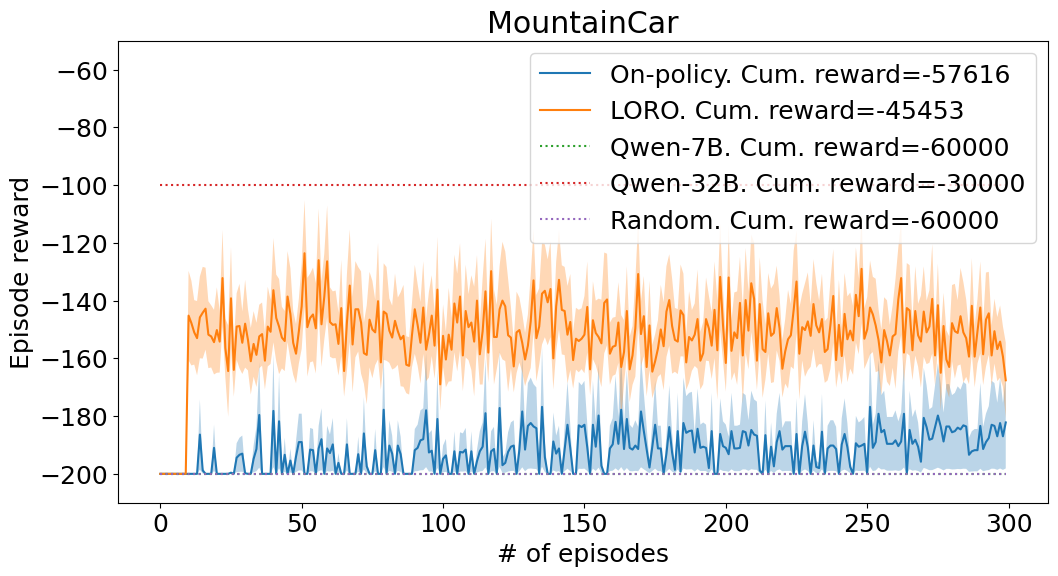

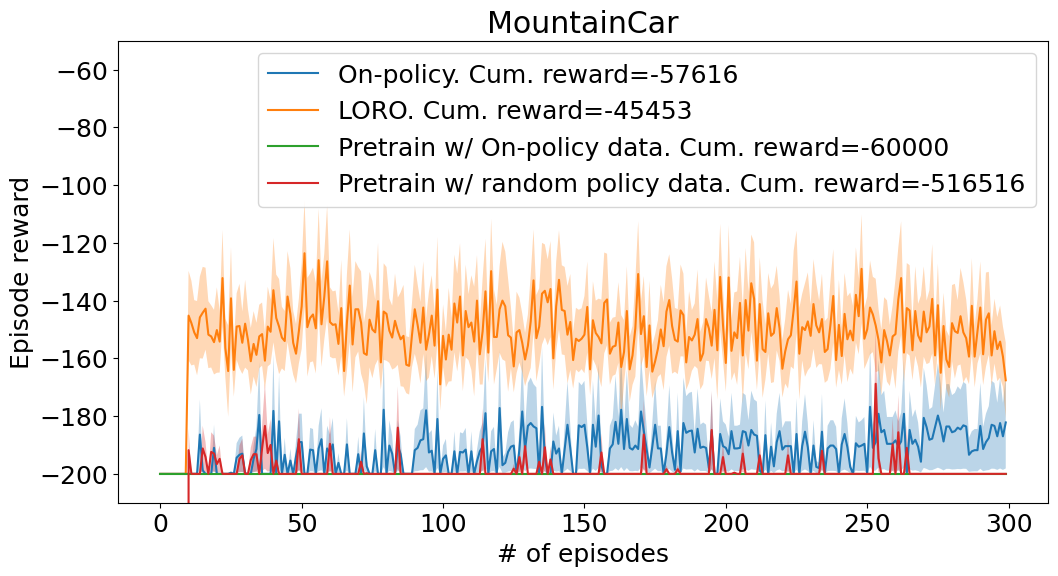

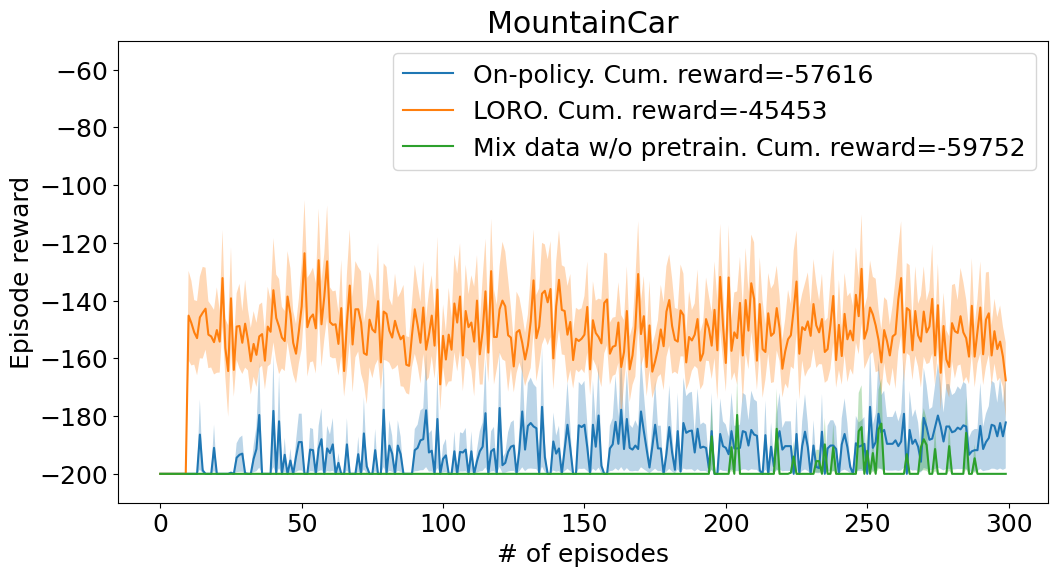

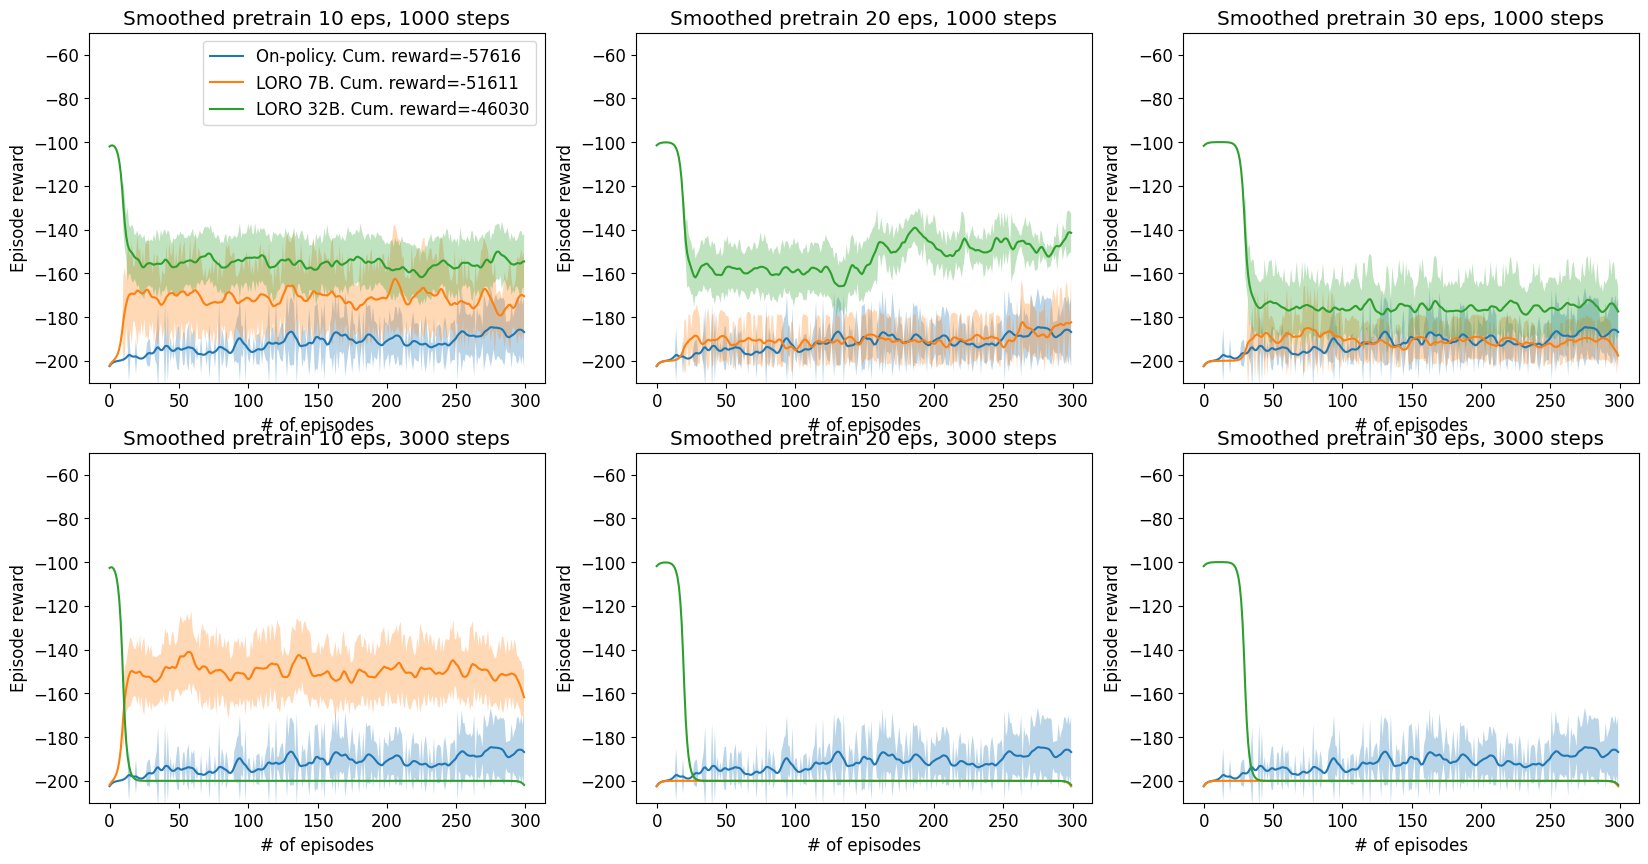

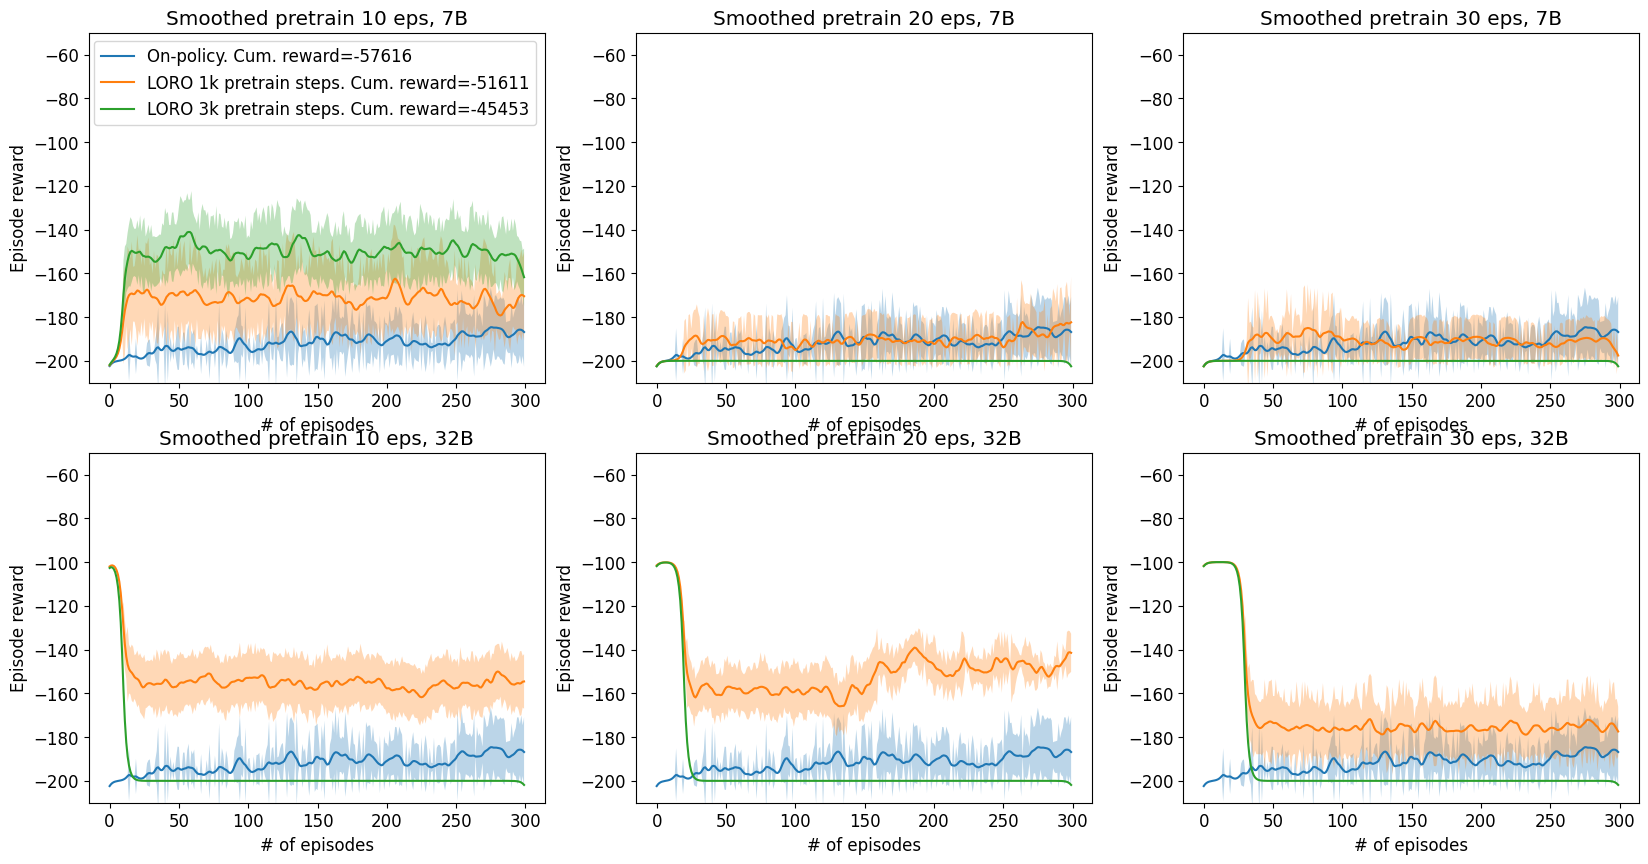

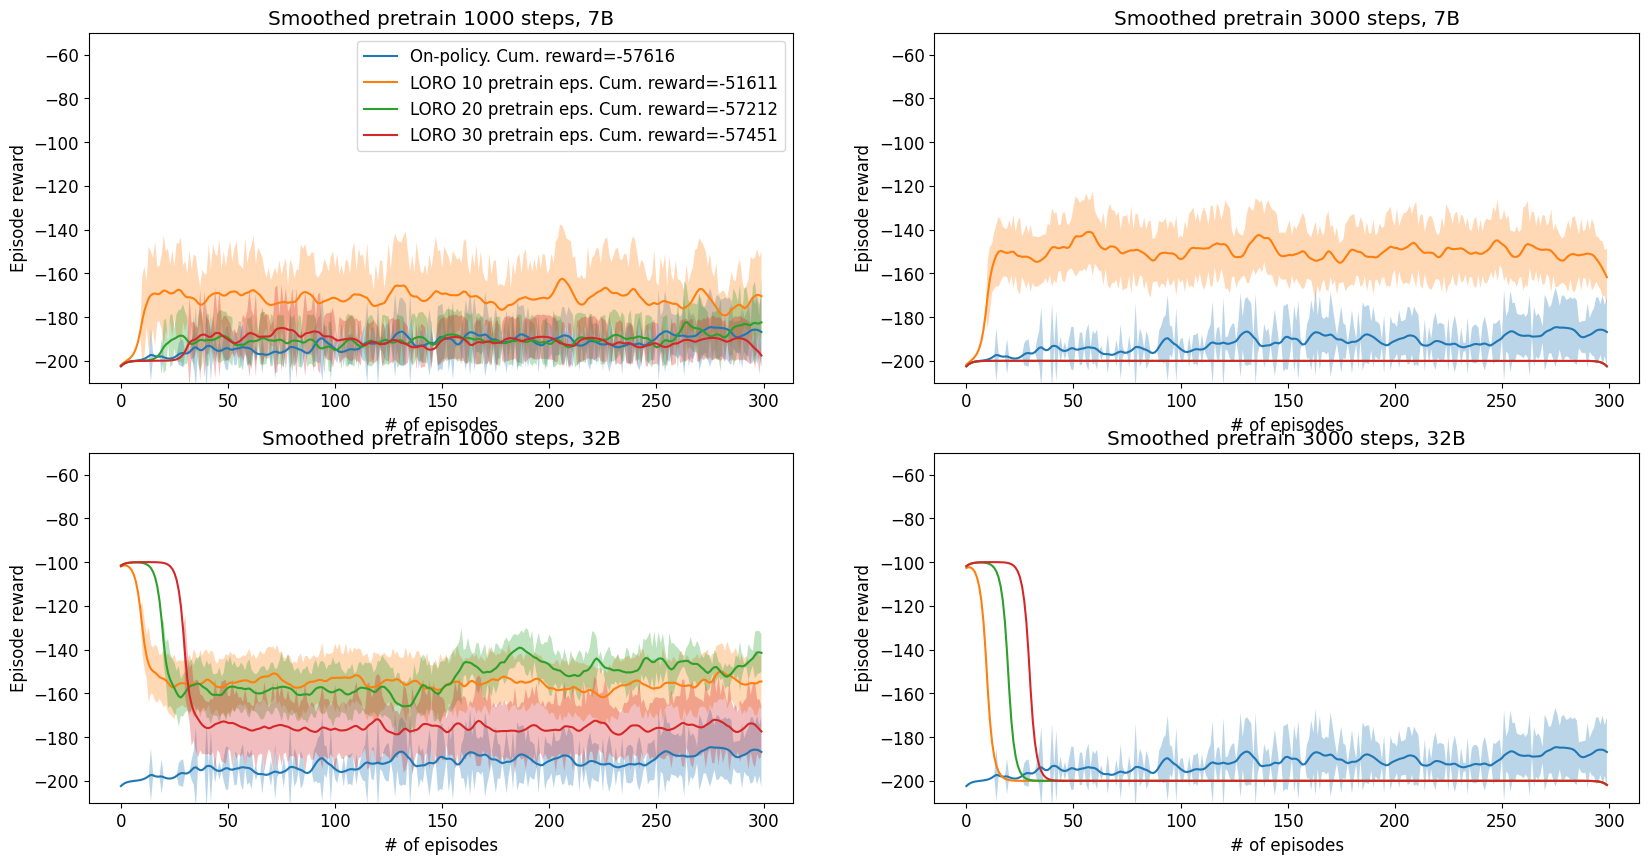

'mean_pretrain_7b_1000_pre_10SFT'
'mean_pretrain_7b_1000_pre_20SFT'
'mean_pretrain_7b_1000_pre_30SFT'
'mean_pretrain_7b_3000_pre_10SFT'
'mean_pretrain_7b_3000_pre_20SFT'
'mean_pretrain_7b_3000_pre_30SFT'


/var/folders/pq/3djhrh750zv53df3bfpn596r0000gn/T/ipykernel_7820/2734472574.py:357: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0,0].legend(loc='upper right')


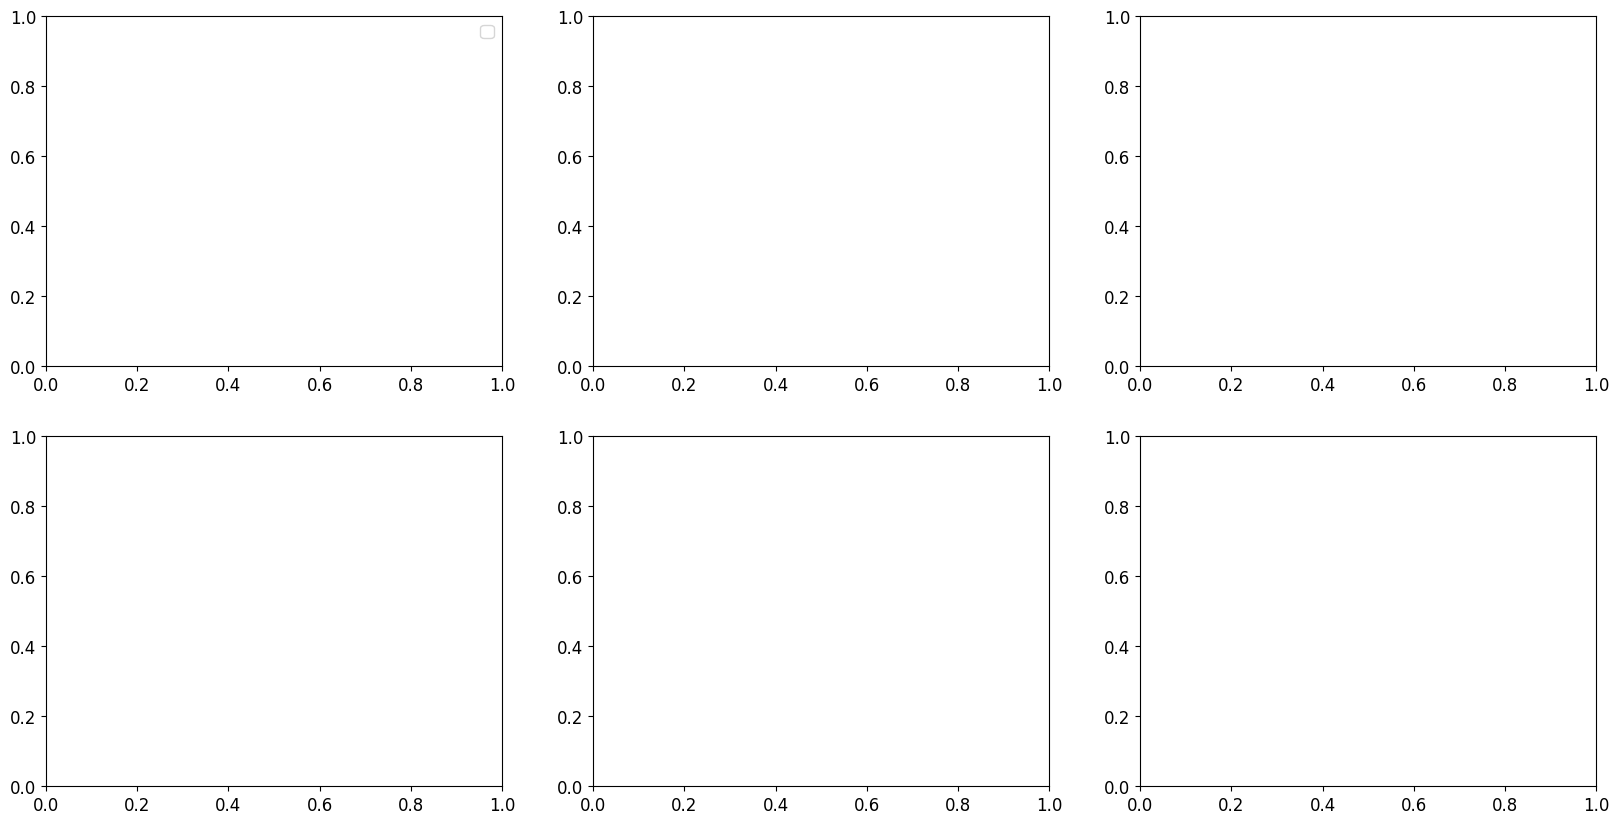

In [111]:
all_cache = extract_data(hyperparams, Qwen_7B, Qwen_32B, DS_7B, DS_14B, Qwen_7B_SFT)
plot_main(hyperparams, all_cache)
plot_pretrain(hyperparams, all_cache)
# plot_pretrain_big(hyperparams, all_cache)
plot_mix(hyperparams, all_cache)
plot_model_size(hyperparams, all_cache)
plot_pretrain_step(hyperparams, all_cache)
plot_pretrain_eps(hyperparams, all_cache)
# plot_sft_lcot(hyperparams, all_cache)
plot_sft_lcot_big(hyperparams, all_cache)